In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from src.utilities.frontier_tools import get_pareto_points, get_all_backtests_df, get_all_seed_frontiers, \
                           get_critical_t, get_mean_margin_of_err, get_bin_intervals, get_bin_means_margin_of_errors, \
                           get_mean_frontier_with_CI

# Get seeded frontiers

In [2]:
MARKET_NAMES = ['DOW_30'] #['DOW_30', 'NIK_25', 'LA_40']
MODEL_BASE_NAMES = ['RL_CNN'] #['RL_CNN', 'RL_str_fcast', 'RL_all_inp' ]

[1/1]	market: DOW_30	model: RL_CNN...
	plot saved.	df saved.
CPU times: user 1.71 s, sys: 339 ms, total: 2.05 s
Wall time: 1.38 s


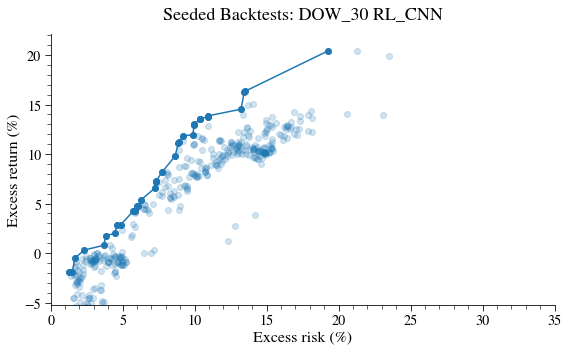

In [10]:
%%time
# gat all backtest results for the specified model on the specified market
# then get the pareto frontier for each seed vale
# plot pareto frontiers and save final DataFrame with all results
counter = 0
total = len(MARKET_NAMES) * len(MODEL_BASE_NAMES)
for market_name in MARKET_NAMES:
    for model_name in MODEL_BASE_NAMES:
        counter += 1
        print(f'[{counter}/{total}]\tmarket: {market_name}\tmodel: {model_name}...')
        data_dir = f'../experiments/{market_name}/seeded/{model_name}/backtests/'        
        results_df = get_all_backtests_df(data_dir)
        all_seed_frontiers_df = get_all_seed_frontiers(results_df, 
                                                       data_dir, 
                                                       market_name, 
                                                       model_name, 
                                                       plot_all_pts=True, 
                                                       alpha=0.2, 
                                                       figsize=(8,5), 
                                                       xlim=(0,35), ylim=(-5.20)
                                                      )
        
## Plot limits for markets
# DOW_30: xlim=(0,35), ylim=(-2.20)
# NIK_25: xlim=(0,25), ylim=(-5,25)
# LA_40: xlim=(0,40), ylim=(-30,30)

In [4]:
all_seed_frontiers_df.shape

(34, 8)

In [5]:
all_seed_frontiers_df.head()

,gamma_trade,gamma_risk,gamma_hold,seed,excess_return,excess_risk,sharpe,is_pareto
0,100,500.0,100.0,0,-1.914923,1.244722,-1.538434,True
1,50,200.0,10.0,0,-1.884254,1.513436,-1.245017,True
2,500,1000.0,100.0,0,-0.526399,1.668100,-0.315568,True
3,500,1000.0,1000.0,0,0.303385,2.324839,0.130497,True
4,10,75.0,100.0,0,0.776977,3.671567,0.211620,True


In [6]:
all_seed_frontiers_df.sort_values('excess_risk')

,gamma_trade,gamma_risk,gamma_hold,seed,excess_return,excess_risk,sharpe,is_pareto
0,100,500.0,100.0,0,-1.914923,1.244722,-1.538434,True
1,50,200.0,10.0,0,-1.884254,1.513436,-1.245017,True
2,500,1000.0,100.0,0,-0.526399,1.668100,-0.315568,True
3,500,1000.0,1000.0,0,0.303385,2.324839,0.130497,True
4,10,75.0,100.0,0,0.776977,3.671567,0.211620,True
5,500,500.0,100.0,0,1.771701,3.846440,0.460608,True
6,1,300.0,1000.0,0,1.987749,4.481478,0.443548,True
7,50,100.0,100.0,0,2.825300,4.582395,0.616555,True
8,50,300.0,1000.0,0,2.864021,4.860852,0.589201,True
9,50,75.0,1.0,0,4.219703,5.730256,0.736390,True


# Get mean frontiers with 95% CI

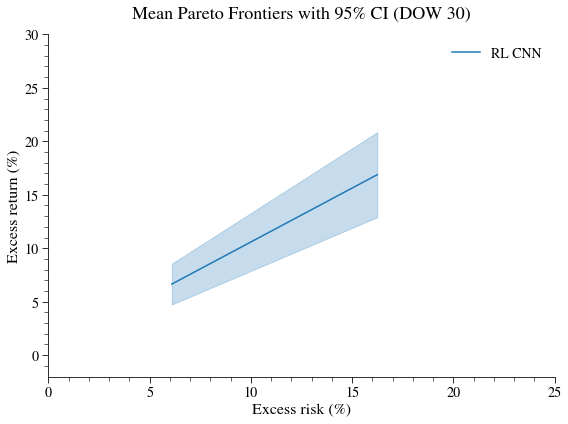

In [7]:
# plot all mean frontiers with their 95%CIs
# and save all points in .csv files

figsize=(8,6)
conf_lvl=0.95
xlim=(0,25)
ylim=(-2,30)

for market_name in MARKET_NAMES:
    fig, ax = plt.subplots(figsize=figsize, facecolor=None, edgecolor=None)
    for i, model_name in enumerate(MODEL_BASE_NAMES):
        x_mids, y_means, y_margin_of_errs = get_mean_frontier_with_CI(market_name, model_name, 
                                                              bin_width=None, min_in_bin=30, 
                                                              conf_lvl=conf_lvl, plot=False, save_plot=False, 
                                                              figsize=figsize, xlim=xlim, ylim=ylim, data_loc='../experiments/')
        
        # save mean frontier with CI in .csv file
        mean_frontier_results_df = pd.DataFrame({'excess_risk':x_mids, 'mean_excess_return':y_means, 'marg_of_err':y_margin_of_errs})
        data_dir = f'../experiments/{market_name}/seeded/{model_name}/backtests/'
        mean_frontier_results_df.to_csv(f'{data_dir}{market_name}_{model_name}_mean_frontier.csv', index=False)
        
        # plot frontier
        ax.plot(x_mids, y_means, f'C{i}-', alpha=1.0, label=f'{model_name.replace("_"," ")}')
        ax.fill_between(x_mids, (y_means-y_margin_of_errs), (y_means+y_margin_of_errs), color=f'C{i}', alpha=0.25)

        ax.set_xlabel('Excess risk (%)')
        ax.set_ylabel('Excess return (%)')
        ax.set_title(f'Mean Pareto Frontiers with {int(conf_lvl*100)}% CI ({market_name.replace("_"," ")})')
        ax.legend();

        ax.set_xlim(left=xlim[0], right=xlim[1])
        ax.set_ylim(bottom=ylim[0], top=ylim[1])
        
        # save figure
        plt.savefig(f'{data_dir}{market_name}_mean_frontiers.png', dpi=150, facecolor=None, edgecolor=None, bbox_inches='tight')

In [8]:
print('done.')

done.


In [9]:
# next get mean frontiers with 95% CIs
# and get hypervolumes